# Toronto Neighborhoods Analysis - Clustering

### Use case

This study is aimed to help a small vegan restaurant/bar willing to open a new location in Toronto. The investors easily agreed to expand their activities in one of its neighborhoods as Toronto is the most populated city in Canada with high quality of living. 
Beyond this information, the investors seem to struggle in gathering sufficient details that will help them identify the appropriate location in Toronto where to establish their facility. Therefore, they requested an analysis of the Toronto market to drive their decision.

The suitable location is described as follow by the investors: 
-	A neighborhood with an average to above average total population
-	Above average populations of 25–40-year-old male and female professionals
-	A high concentration of the population having higher education
-	Average to above average net household incomes
-	Average to above average employment rate
-	A high concentration of the population showing environmental awareness

The goal of this analysis is to identify and recommend to the investors which neighborhood(s) of Toronto will be the best choice to establish their facility. The target audience is vegan oriented businesses and restaurants/bars. Starting from these requirements and using data about neighborhoods population, activities and venues, the study will highlight most attractive opportunities.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from bs4 import BeautifulSoup # library for web scrapping

import requests # library to handle api requests

import lxml.html as lh # html parser 

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')

Libraries imported.


## 1. Data Collection

### Neighborhood Profiles

Loading information about age and sex, families and households, language, immigration and internal migration, ethnocultural diversity, Aboriginal peoples, housing, education, income, and labor for each neighborhoods in Toronto.

In [2]:
neighborhood = pd.read_csv('C:/Users/m.rachidi/Desktop/Capstone_Project/Datasets/neighbourhood-profiles.csv')
neighborhood.head(3)

_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
1    2  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   

                      Data Source        Characteristic City of Toronto  \
0                 City of Toronto  Neighbourhood Number             NaN   
1                 City of Toronto  TSNS2020 Designation             NaN   
2  Census Profile 98-316-X2016001      Population, 2016       2,731,571   

  Agincourt North Agincourt South-Malvern West       Alderwood  \
0             129                          128              20   
1  No Designation               No Designation  No Designation   
2          29,113                       23,757          12,054   

            Annex  ... Willowdale West Willowridge-Martingrove-Richview  \
0              95  ...              37                                7   
1  No Designation  ...  No Designation                   No Designation   
2          30,526  ...          16,936                           22,156   

   Woburn Woodbine Corridor Woodbine-Lumsden        Wychwood  Yonge-Eglinton  \
0     137                64               60              94             100   
1     NIA    No Designation   No Designation  No Designation  No Designation   
2  53,485            12,541            7,865          14,349          11,817   

   Yonge-St.Clair York University Heights      Yorkdale-Glen Park  
0              97                      27                      31  
1  No Designation                     NIA  Emerging Neighbourhood  
2          12,528                  27,593                  14,804  

[3 rows x 146 columns]

### Neighborhood Shapes

Loading GeoJSON data about boundaries of City of Toronto Neighborhoods that will be used for mapping purposes.

In [3]:
with open('C:/Users/m.rachidi/Desktop/Capstone_Project/Datasets/Neighbourhoods.geojson') as file:
    shapes = json.load(file)

### Neighborhood Boroughs

Collecting additional information about Toronto Boroughs using web scrapping.

In [4]:
# Connect to website
url = 'https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto'
response = requests.get(url)

# Get data from html document
soup = BeautifulSoup(response.text, 'html.parser')
rows = soup.table.tbody.find_all('tr')

table = []
for i in range(1,len(rows)):
    tds = rows[i].find_all('td')
    values = [td.text.replace('\n','') for td in tds]
    table.append(values)


# Convert to dataframe
labels = ["CDN","Neighborhood","Borough","Map","Empty",'Other']
borough = pd.DataFrame(table, columns=labels)

borough.drop(columns=['Empty','Other'], axis=1, inplace=True)
borough.head()

# # Upload to csv file
# path = 'C:/Users/m.rachidi/Desktop/Capstone_Project/Datasets/toronto_boroughs.csv'
# borough.to_csv(path_or_buf=path)

CDN                  Neighborhood              Borough  \
0  129               Agincourt North          Scarborough   
1  128  Agincourt South-Malvern West          Scarborough   
2   20                     Alderwood            Etobicoke   
3   95                         Annex  Old City of Toronto   
4   42             Banbury-Don Mills           North York   

                            Map  
0        Agincourt and Brimwood  
1         Agincourt and Malvern  
2                     Alderwood  
3  The Annex and Seaton Village  
4                     Don Mills

### Neighborhood Venues

Collecting data about venues in each neighborhood from Foursquare API. However, we need to perform some data preprocessing in order to gather location data that will be used as input to the API.

In [33]:
# Foursquare credentials and version
CLIENT_ID = 'QXLFWM3YP25B3SFMEIWYW2OUVSV3WZJ2OZ3KUWSS3YO0LJX5'
CLIENT_SECRET = 'QDFNA422OM0X2I5NKTBSJOZF4KVED0ZLSND4DPMNOYACLMOX'
VERSION = '20180605'

# Get the top 100 venues for all Toronto neighborhoods
def getAllVenues(names, latitudes, longitudes, radius=1000, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # Get url 
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # Get response
        venues = requests.get(url).json()['response']['groups'][0]['items']
        
        
        # Get only desired values
        for i in venues:
            venues_list.append((name,
                                i['venue']['name'], 
                                i['venue']['location']['lat'], 
                                i['venue']['location']['lng'],
                                i['venue']['categories'][0]['name']))
            
    # Create dataframe
    venues_df = pd.DataFrame(venues_list, columns=['Neighborhoods',  
                                                   'Venue', 
                                                   'Venue Latitude', 
                                                   'Venue Longitude', 
                                                   'Venue Category'])
    
    return venues_df

## 2. Data Preprocessing and Cleaning

In [6]:
# Explore the data
neighborhood['Characteristic'] = neighborhood['Characteristic'].str.strip()
neighborhood['Characteristic'].unique()

array(['Neighbourhood Number', 'TSNS2020 Designation', 'Population, 2016',
       ..., 'Interprovincial migrants', 'External migrants',
       'Total - Mobility status 5 years ago - 25% sample data'],
      dtype=object)

In [7]:
# Keep useful columns 
drop_columns = ['_id','Category','Topic','Data Source']
neigh = neighborhood.drop(columns=drop_columns, axis=1)
neigh.head()

Characteristic City of Toronto Agincourt North  \
0         Neighbourhood Number             NaN             129   
1         TSNS2020 Designation             NaN  No Designation   
2             Population, 2016       2,731,571          29,113   
3             Population, 2011       2,615,060          30,279   
4  Population Change 2011-2016           4.50%          -3.90%   

  Agincourt South-Malvern West       Alderwood           Annex  \
0                          128              20              95   
1               No Designation  No Designation  No Designation   
2                       23,757          12,054          30,526   
3                       21,988          11,904          29,177   
4                        8.00%           1.30%           4.60%   

  Banbury-Don Mills  Bathurst Manor Bay Street Corridor Bayview Village  ...  \
0                42              34                  76              52  ...   
1    No Designation  No Designation      No Designation  No Designation  ...   
2            27,695          15,873              25,797          21,396  ...   
3            26,918          15,434              19,348          17,671  ...   
4             2.90%           2.80%              33.30%          21.10%  ...   

  Willowdale West Willowridge-Martingrove-Richview  Woburn Woodbine Corridor  \
0              37                                7     137                64   
1  No Designation                   No Designation     NIA    No Designation   
2          16,936                           22,156  53,485            12,541   
3          15,004                           21,343  53,350            11,703   
4          12.90%                            3.80%   0.30%             7.20%   

  Woodbine-Lumsden        Wychwood  Yonge-Eglinton  Yonge-St.Clair  \
0               60              94             100              97   
1   No Designation  No Designation  No Designation  No Designation   
2            7,865          14,349          11,817          12,528   
3            7,826          13,986          10,578          11,652   
4            0.50%           2.60%          11.70%           7.50%   

  York University Heights      Yorkdale-Glen Park  
0                      27                      31  
1                     NIA  Emerging Neighbourhood  
2                  27,593                  14,804  
3                  27,713                  14,687  
4                  -0.40%                   0.80%  

[5 rows x 142 columns]

In [8]:
print(f'The shape of neigh dataframe is : {neigh.shape}')
length = len(neigh['Characteristic'].unique())
print(f'There are {length} unique charachteristics')

The shape of neigh dataframe is : (2383, 142)
There are 1331 unique charachteristics


In [9]:
# Feature selection
selected_characteristics = ['Average after-tax income of households in 2015 ($)', 'Employment rate',
                            'Postsecondary certificate, diploma or degree', 'Working Age (25-54 years)', 
                            'Population, 2016','Neighbourhood Number']


neigh = neigh[neigh['Characteristic'].isin(selected_characteristics)].reset_index(drop=True)

In [10]:
neigh['Characteristic']

0                                 Neighbourhood Number
1                                     Population, 2016
2                            Working Age (25-54 years)
3    Average after-tax income of households in 2015...
4         Postsecondary certificate, diploma or degree
5         Postsecondary certificate, diploma or degree
6         Postsecondary certificate, diploma or degree
7         Postsecondary certificate, diploma or degree
8                                      Employment rate
Name: Characteristic, dtype: object

In [11]:
# Drop duplicate rows because 4 characteristics have similar name as we used .isin() method
neigh.drop([neigh.index[5],neigh.index[6],neigh.index[7]], inplace=True)
neigh.head()

Characteristic City of Toronto  \
0                               Neighbourhood Number             NaN   
1                                   Population, 2016       2,731,571   
2                          Working Age (25-54 years)       1,229,555   
3  Average after-tax income of households in 2015...          81,495   
4       Postsecondary certificate, diploma or degree         1356360   

  Agincourt North Agincourt South-Malvern West Alderwood    Annex  \
0             129                          128        20       95   
1          29,113                       23,757    12,054   30,526   
2          11,305                        9,965     5,220   15,040   
3         427,037                      278,390   168,602  792,507   
4           10985                        10285      5300    20430   

  Banbury-Don Mills Bathurst Manor Bay Street Corridor Bayview Village  ...  \
0                42             34                  76              52  ...   
1            27,695         15,873              25,797          21,396  ...   
2            10,810          6,655              13,065          10,310  ...   
3           493,486        251,583             352,218         354,894  ...   
4             15950           8200               17505           13740  ...   

  Willowdale West Willowridge-Martingrove-Richview   Woburn Woodbine Corridor  \
0              37                                7      137                64   
1          16,936                           22,156   53,485            12,541   
2           7,480                            8,140   21,945             6,165   
3         272,986                          412,302  629,030           240,272   
4           10315                             9935    21370              6620   

  Woodbine-Lumsden Wychwood Yonge-Eglinton Yonge-St.Clair  \
0               60       94            100             97   
1            7,865   14,349         11,817         12,528   
2            3,790    6,420          5,860          5,960   
3          147,462  239,484        222,648        541,217   
4             3920     7230           7990           8820   

  York University Heights Yorkdale-Glen Park  
0                      27                 31  
1                  27,593             14,804  
2                  12,290              5,860  
3                 302,358            213,860  
4                   11420               5240  

[5 rows x 142 columns]

In [12]:
print(f'The shape of neigh dataframe is now : {neigh.shape}')
length = len(neigh['Characteristic'].unique())
print(f'There are now {length} unique charachteristics')

The shape of neigh dataframe is now : (6, 142)
There are now 6 unique charachteristics


In [13]:
neigh.set_index('Characteristic', inplace=True)
neigh = neigh.T
neigh.reset_index(inplace=True)
neigh.rename(columns={'index':'Neighborhoods'}, inplace=True)
neigh.head()

Characteristic                 Neighborhoods Neighbourhood Number  \
0                            City of Toronto                  NaN   
1                            Agincourt North                  129   
2               Agincourt South-Malvern West                  128   
3                                  Alderwood                   20   
4                                      Annex                   95   

Characteristic Population, 2016 Working Age (25-54 years)  \
0                     2,731,571                 1,229,555   
1                        29,113                    11,305   
2                        23,757                     9,965   
3                        12,054                     5,220   
4                        30,526                    15,040   

Characteristic Average after-tax income of households in 2015 ($)  \
0                                                          81,495   
1                                                         427,037   
2                                                         278,390   
3                                                         168,602   
4                                                         792,507   

Characteristic Postsecondary certificate, diploma or degree Employment rate  
0                                                   1356360            59.3  
1                                                     10985              50  
2                                                     10285            53.2  
3                                                      5300            62.4  
4                                                     20430            65.8

In [14]:
# Check data types 
neigh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
Neighborhoods                                         141 non-null object
Neighbourhood Number                                  140 non-null object
Population, 2016                                      141 non-null object
Working Age (25-54 years)                             141 non-null object
Average after-tax income of households in 2015 ($)    141 non-null object
Postsecondary certificate, diploma or degree          141 non-null object
Employment rate                                       141 non-null object
dtypes: object(7)
memory usage: 7.8+ KB


In [15]:
# Check for missing values
neigh.isnull().sum()

Characteristic
Neighborhoods                                         0
Neighbourhood Number                                  1
Population, 2016                                      0
Working Age (25-54 years)                             0
Average after-tax income of households in 2015 ($)    0
Postsecondary certificate, diploma or degree          0
Employment rate                                       0
dtype: int64

In [16]:
# Replace values where ',' separator with ''
columns = neigh.columns
for i in range(len(columns)):
    neigh.iloc[:, i] = neigh.iloc[:, i].str.replace(",","")
    
neigh

Characteristic                 Neighborhoods Neighbourhood Number  \
0                            City of Toronto                  NaN   
1                            Agincourt North                  129   
2               Agincourt South-Malvern West                  128   
3                                  Alderwood                   20   
4                                      Annex                   95   
..                                       ...                  ...   
136                                 Wychwood                   94   
137                           Yonge-Eglinton                  100   
138                           Yonge-St.Clair                   97   
139                  York University Heights                   27   
140                       Yorkdale-Glen Park                   31   

Characteristic Population, 2016 Working Age (25-54 years)  \
0                       2731571                   1229555   
1                         29113                     11305   
2                         23757                      9965   
3                         12054                      5220   
4                         30526                     15040   
..                          ...                       ...   
136                       14349                      6420   
137                       11817                      5860   
138                       12528                      5960   
139                       27593                     12290   
140                       14804                      5860   

Characteristic Average after-tax income of households in 2015 ($)  \
0                                                           81495   
1                                                          427037   
2                                                          278390   
3                                                          168602   
4                                                          792507   
..                                                            ...   
136                                                        239484   
137                                                        222648   
138                                                        541217   
139                                                        302358   
140                                                        213860   

Characteristic Postsecondary certificate, diploma or degree Employment rate  
0                                                   1356360            59.3  
1                                                     10985              50  
2                                                     10285            53.2  
3                                                      5300            62.4  
4                                                     20430            65.8  
..                                                      ...             ...  
136                                                    7230            65.6  
137                                                    7990            68.2  
138                                                    8820            65.2  
139                                                   11420            56.3  
140                                                    5240            55.3  

[141 rows x 7 columns]

In [17]:
# Convert data to float
neigh.iloc[:, 1:] = neigh.iloc[:, 1:].astype(float)

In [18]:
# Rename columns
replace_values = {'Population, 2016':'Population','Working Age (25-54 years)':'Adults',
                   'Average after-tax income of households in 2015 ($)':'Avg income',
                   'Postsecondary certificate, diploma or degree':'Higher education','Neighbourhood Number':'CDN'}

neigh.rename(columns=replace_values, inplace=True)
neigh.head()

Characteristic                 Neighborhoods  CDN   Population       Adults  \
0                            City of Toronto  NaN  2.73157e+06  1.22956e+06   
1                            Agincourt North  129        29113        11305   
2               Agincourt South-Malvern West  128        23757         9965   
3                                  Alderwood   20        12054         5220   
4                                      Annex   95        30526        15040   

Characteristic Avg income Higher education Employment rate  
0                   81495      1.35636e+06            59.3  
1                  427037            10985              50  
2                  278390            10285            53.2  
3                  168602             5300            62.4  
4                  792507            20430            65.8

In [84]:
toronto_total = neigh.iloc[0,:]
neighborhood = neigh.iloc[1:]

# Check for shape, data types and missing values
print(f'The shape of the neighborhood dataframe is {neighborhood.shape}','\n')
print(f'Data types are :\n{neighborhood.dtypes}','\n')
print(f'There is no missing values \n{neighborhood.isnull().sum()}')

neighborhood.head()

### Merge additionnal features

#### Borough Dataset

In [20]:
borough.head()

CDN                  Neighborhood              Borough  \
0  129               Agincourt North          Scarborough   
1  128  Agincourt South-Malvern West          Scarborough   
2   20                     Alderwood            Etobicoke   
3   95                         Annex  Old City of Toronto   
4   42             Banbury-Don Mills           North York   

                            Map  
0        Agincourt and Brimwood  
1         Agincourt and Malvern  
2                     Alderwood  
3  The Annex and Seaton Village  
4                     Don Mills

In [21]:
# Check for shape, data types and missing values
print(f'The shape of the borough dataframe is {borough.shape}','\n')
print(f'Data types are :\n{borough.dtypes}','\n')
print(f'There is no missing values \n{borough.isnull().sum()}')

The shape of the borough dataframe is (140, 4) 

Data types are :
CDN             object
Neighborhood    object
Borough         object
Map             object
dtype: object 

There is no missing values 
CDN             0
Neighborhood    0
Borough         0
Map             0
dtype: int64


In [22]:
# Get borough for each neighborhood
neighborhood['CDN'] = neighborhood['CDN'].astype('int64')
borough['CDN'] = borough['CDN'].astype('int64')

# Merge data
neighborhood = pd.merge(neighborhood, borough, how='left', on='CDN')
neighborhood.head()

Neighborhoods  CDN Population Adults Avg income  \
0               Agincourt North  129      29113  11305     427037   
1  Agincourt South-Malvern West  128      23757   9965     278390   
2                     Alderwood   20      12054   5220     168602   
3                         Annex   95      30526  15040     792507   
4             Banbury-Don Mills   42      27695  10810     493486   

  Higher education Employment rate                  Neighborhood  \
0            10985              50               Agincourt North   
1            10285            53.2  Agincourt South-Malvern West   
2             5300            62.4                     Alderwood   
3            20430            65.8                         Annex   
4            15950            55.6             Banbury-Don Mills   

               Borough                           Map  
0          Scarborough        Agincourt and Brimwood  
1          Scarborough         Agincourt and Malvern  
2            Etobicoke                     Alderwood  
3  Old City of Toronto  The Annex and Seaton Village  
4           North York                     Don Mills

In [23]:
# Filter columns
neighborhood.drop(columns=(['Neighborhood','Map']), axis=1,inplace=True)

# Order all columns
columns = [neighborhood.columns[0]] + [neighborhood.columns[-1]] + list(neighborhood.columns[1:-1])
neighborhood = neighborhood[columns]
neighborhood.head()

Neighborhoods              Borough  CDN Population Adults  \
0               Agincourt North          Scarborough  129      29113  11305   
1  Agincourt South-Malvern West          Scarborough  128      23757   9965   
2                     Alderwood            Etobicoke   20      12054   5220   
3                         Annex  Old City of Toronto   95      30526  15040   
4             Banbury-Don Mills           North York   42      27695  10810   

  Avg income Higher education Employment rate  
0     427037            10985              50  
1     278390            10285            53.2  
2     168602             5300            62.4  
3     792507            20430            65.8  
4     493486            15950            55.6

#### Shape Dataset

In [24]:
# Get cooridinates for each neighborhood
table = []
for i in shapes['features']:
    records = []
    records.append(i['properties']['AREA_SHORT_CODE'])
    records.append(i['properties']['AREA_NAME'])
    records.append(i['properties']['LONGITUDE'])
    records.append(i['properties']['LATITUDE'])
    table.append(records)
    
labels = ['CDN','Neighborhood','Longitude','Latitude']
location = pd.DataFrame(table, columns=labels)
location.head()

CDN                  Neighborhood  Longitude   Latitude
0   94                 Wychwood (94) -79.425515  43.676919
1  100          Yonge-Eglinton (100) -79.403590  43.704689
2   97           Yonge-St.Clair (97) -79.397871  43.687859
3   27  York University Heights (27) -79.488883  43.765736
4   31       Yorkdale-Glen Park (31) -79.457108  43.714672

In [25]:
# Check for shape, data types and missing values
print(f'The shape of the location dataframe is {location.shape}','\n')
print(f'Data types are :\n{location.dtypes}','\n')
print(f'There is no missing values \n{location.isnull().sum()}')

The shape of the location dataframe is (140, 4) 

Data types are :
CDN               int64
Neighborhood     object
Longitude       float64
Latitude        float64
dtype: object 

There is no missing values 
CDN             0
Neighborhood    0
Longitude       0
Latitude        0
dtype: int64


In [26]:
# Merge data
neighborhood = pd.merge(neighborhood, location, how='left', on='CDN')

# Filter columns
neighborhood.drop(columns=(['Neighborhood']), axis=1,inplace=True)
neighborhood.head()

Neighborhoods              Borough  CDN Population Adults  \
0               Agincourt North          Scarborough  129      29113  11305   
1  Agincourt South-Malvern West          Scarborough  128      23757   9965   
2                     Alderwood            Etobicoke   20      12054   5220   
3                         Annex  Old City of Toronto   95      30526  15040   
4             Banbury-Don Mills           North York   42      27695  10810   

  Avg income Higher education Employment rate  Longitude   Latitude  
0     427037            10985              50 -79.266712  43.805441  
1     278390            10285            53.2 -79.265612  43.788658  
2     168602             5300            62.4 -79.541611  43.604937  
3     792507            20430            65.8 -79.404001  43.671585  
4     493486            15950            55.6 -79.349718  43.737657

In [27]:
# Convert data to float
neighborhood.iloc[:, 3:] = neighborhood.iloc[:, 3:].astype('float64')

# Get median values to meet investors criteria for: 
# population, net avg income, education, employment rate, adult between 25-54
neighborhood.median()

CDN                     70.500000
Population           16749.500000
Adults                7475.000000
Avg income          291549.500000
Higher education      8225.000000
Employment rate         58.550000
Longitude              -79.403989
Latitude                43.702021
dtype: float64

## 3. Explore Toronto Neighborhoods

In [28]:
# # !conda install -c conda-forge geopandas
# import geopandas as gpd

# toronto_gpd = gpd.read_file('C:/Users/m.rachidi/Desktop/Capstone_Project/Datasets/Neighbourhoods.geojson')
# toronto_gpd.head()

In [29]:
# communities_map = folium.Map(location=[latitude, longitude], zoom_start=5, tiles='stamenwatercolor')

# # generate choropleth map 
# communities_map.choropleth(
#     geo_data=toronto_gpd,
#     data=toronto_gpd,
#     columns=['AREA_NAME', 'Shape__Length'],
#     key_on='feature.properties.name',
#     fill_color='YlGnBu', 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Births per 1000 inhabitants',
#     smooth_factor=0)

# # display map
# communities_map

In [30]:
# Get Toronto latitude and longitude
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [31]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10, height=500)

# add markers to map
for lat, lng, borough, neigh in zip(neighborhood['Latitude'], neighborhood['Longitude'], neighborhood['Borough'], neighborhood['Neighborhoods']):
    label = '{}, {}'.format(neigh, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#750080',
        fill=True,
        fill_color='#800080',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 

map_toronto

### Calling Foursquare API 

In [37]:
# Collecting data about venues for each neighborhoods 
# The query crashes sometimes and need to run again this cell until all neighborhoods get printed
toronto_venues = getAllVenues(names=neighborhood['Neighborhoods'],
                              latitudes=neighborhood['Latitude'],
                              longitudes=neighborhood['Longitude'])

Agincourt North
Agincourt South-Malvern West
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park-Nortown
Beechborough-Greenbrook
Bendale
Birchcliffe-Cliffside
Black Creek
Blake-Jones
Briar Hill-Belgravia
Bridle Path-Sunnybrook-York Mills
Broadview North
Brookhaven-Amesbury
Cabbagetown-South St. James Town
Caledonia-Fairbank
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson-Junction
Downsview-Roding-CFB
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Eringate-Centennial-West Deane
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Hu

In [38]:
# Check for shape and missing values
print(f'The shape of the toronto_venues dataframe is {toronto_venues.shape}','\n')
print(f'There is no missing values \n{toronto_venues.isnull().sum()}')

toronto_venues.head()

The shape of the toronto_venues dataframe is (5705, 5) 

There is no missing values 
Neighborhoods      0
Venue              0
Venue Latitude     0
Venue Longitude    0
Venue Category     0
dtype: int64


Neighborhoods                                     Venue  Venue Latitude  \
0  Agincourt North                                 Menchie's       43.808338   
1  Agincourt North  Saravanaa Bhavan South Indian Restaurant       43.810117   
2  Agincourt North                        Shoppers Drug Mart       43.808894   
3  Agincourt North                             Booster Juice       43.809915   
4  Agincourt North          Samosa King - Embassy Restaurant       43.810152   

   Venue Longitude      Venue Category  
0       -79.268288  Frozen Yogurt Shop  
1       -79.269275   Indian Restaurant  
2       -79.269854            Pharmacy  
3       -79.269382           Juice Bar  
4       -79.257316   Indian Restaurant

In [39]:
# How many unique categories are in the dataset ?
print('Number of unique categories: ',len(toronto_venues['Venue Category'].unique()))

Number of unique categories:  353


###  Top 100 venues for each neighborhood

In [40]:
# create map of New York using latitude and longitude values
map_toronto_venues = folium.Map(location=[latitude, longitude], zoom_start=10, height=500)

# add markers to map
for lat, lng, neigh in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Neighborhoods']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='#750080',
        fill=True,
        fill_color='#800080',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_venues) 

map_toronto_venues

### Feature engineering

#### One hot encoding

In [41]:
# Pivot categories: one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.head()

ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    0                  0               0                  0   
1    0                  0               0                  0   
2    0                  0               0                  0   
3    0                  0               0                  0   
4    0                  0               0                  0   

   African Restaurant  American Restaurant  Amphitheater  Animal Shelter  \
0                   0                    0             0               0   
1                   0                    0             0               0   
2                   0                    0             0               0   
3                   0                    0             0               0   
4                   0                    0             0               0   

   Antique Shop  Arcade  ...  Vietnamese Restaurant  Warehouse Store  \
0             0       0  ...                      0                0   
1             0       0  ...                      0                0   
2             0       0  ...                      0                0   
3             0       0  ...                      0                0   
4             0       0  ...                      0                0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
0           0         0          0            0              0            0   
1           0         0          0            0              0            0   
2           0         0          0            0              0            0   
3           0         0          0            0              0            0   
4           0         0          0            0              0            0   

   Zoo  Zoo Exhibit  
0    0            0  
1    0            0  
2    0            0  
3    0            0  
4    0            0  

[5 rows x 353 columns]

In [42]:
# Get the neighborhood columns: warning there is a neighborhood category so we need to change the name of neighborhood column
toronto_onehot['Hood'] = toronto_venues['Neighborhoods']
columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[columns]
toronto_onehot.head()

Hood  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0  Agincourt North    0                  0               0                  0   
1  Agincourt North    0                  0               0                  0   
2  Agincourt North    0                  0               0                  0   
3  Agincourt North    0                  0               0                  0   
4  Agincourt North    0                  0               0                  0   

   African Restaurant  American Restaurant  Amphitheater  Animal Shelter  \
0                   0                    0             0               0   
1                   0                    0             0               0   
2                   0                    0             0               0   
3                   0                    0             0               0   
4                   0                    0             0               0   

   Antique Shop  ...  Vietnamese Restaurant  Warehouse Store  Whisky Bar  \
0             0  ...                      0                0           0   
1             0  ...                      0                0           0   
2             0  ...                      0                0           0   
3             0  ...                      0                0           0   
4             0  ...                      0                0           0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0         0          0            0              0            0    0   
1         0          0            0              0            0    0   
2         0          0            0              0            0    0   
3         0          0            0              0            0    0   
4         0          0            0              0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 354 columns]

In [43]:
# Group avg number of each categories by neighborhood
toronto_grouped = toronto_onehot.groupby(['Hood']).mean().reset_index()
toronto_grouped.head()

Hood  ATM  Accessories Store  Adult Boutique  \
0               Agincourt North  0.0                0.0             0.0   
1  Agincourt South-Malvern West  0.0                0.0             0.0   
2                     Alderwood  0.0                0.0             0.0   
3                         Annex  0.0                0.0             0.0   
4             Banbury-Don Mills  0.0                0.0             0.0   

   Afghan Restaurant  African Restaurant  American Restaurant  Amphitheater  \
0                0.0                 0.0              0.00000           0.0   
1                0.0                 0.0              0.00000           0.0   
2                0.0                 0.0              0.00000           0.0   
3                0.0                 0.0              0.00000           0.0   
4                0.0                 0.0              0.02381           0.0   

   Animal Shelter  Antique Shop  ...  Vietnamese Restaurant  Warehouse Store  \
0             0.0           0.0  ...               0.044444              0.0   
1             0.0           0.0  ...               0.000000              0.0   
2             0.0           0.0  ...               0.000000              0.0   
3             0.0           0.0  ...               0.000000              0.0   
4             0.0           0.0  ...               0.000000              0.0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
0         0.0       0.0        0.0     0.022222        0.00000          0.0   
1         0.0       0.0        0.0     0.000000        0.00000          0.0   
2         0.0       0.0        0.0     0.000000        0.00000          0.0   
3         0.0       0.0        0.0     0.000000        0.00000          0.0   
4         0.0       0.0        0.0     0.000000        0.02381          0.0   

   Zoo  Zoo Exhibit  
0  0.0          0.0  
1  0.0          0.0  
2  0.0          0.0  
3  0.0          0.0  
4  0.0          0.0  

[5 rows x 354 columns]

In [44]:
print(f'The shape of the toronto_grouped dataframe is {toronto_grouped.shape}')

The shape of the toronto_grouped dataframe is (140, 354)


#### Filtering and ranking venues

In [45]:
# Top 5 venues in each neighborhood
for i in toronto_grouped['Hood']:
    print(i, '\n')
    hood = toronto_grouped[toronto_grouped['Hood'] == i].T.reset_index().iloc[1:]
    hood.columns=['Venue','Freq']
    hood['Freq'] = hood['Freq'].astype(float)
    print(hood.sort_values(by='Freq', ascending=False).reset_index(drop=True).head(5), '\n','...')
    break

Agincourt North 

                   Venue      Freq
0     Chinese Restaurant  0.088889
1  Vietnamese Restaurant  0.044444
2            Pizza Place  0.044444
3               Pharmacy  0.044444
4      Indian Restaurant  0.044444 
 ...


In [46]:
# Create dataframe summarizing top 10 most common venue categories for each neighborhood
# 1. Get the columns names
columns = ['Hood','1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']

# 2. Create df and add hood columns to it
top_venues = pd.DataFrame(columns=columns)
top_venues['Hood'] = toronto_grouped['Hood']

# 3. Get the most common values as a list for each neighborhood
for_one_neighborhood = toronto_grouped.iloc[0, 1:].sort_values(ascending=False).index.values[0:10] 

# 4. Loop through all toronto grouped df to append all neighborhoods
for i in np.arange(len(toronto_grouped)):
    top_venues.iloc[i, 1:] = toronto_grouped.iloc[i, 1:].sort_values(ascending=False).index.values[0:10]
    
top_venues.head()

Hood                 1st             2nd  \
0               Agincourt North  Chinese Restaurant  Sandwich Place   
1  Agincourt South-Malvern West  Chinese Restaurant      Food Court   
2                     Alderwood                Park     Gas Station   
3                         Annex                Café      Restaurant   
4             Banbury-Don Mills         Coffee Shop      Restaurant   

                     3rd                   4th           5th  \
0  Vietnamese Restaurant                Bakery   Coffee Shop   
1          Shopping Mall  Cantonese Restaurant    Restaurant   
2            Pizza Place              Pharmacy  Intersection   
3            Coffee Shop    Italian Restaurant        Bakery   
4                   Café                  Bank   Pizza Place   

                   6th                            7th                  8th  \
0                 Bank              Indian Restaurant       Discount Store   
1       Clothing Store             Seafood Restaurant         Noodle House   
2        Grocery Store                            Gym       Sandwich Place   
3    French Restaurant  Vegetarian / Vegan Restaurant  Japanese Restaurant   
4  Japanese Restaurant      Middle Eastern Restaurant     Botanical Garden   

             9th                 10th  
0       Pharmacy          Pizza Place  
1         Lounge          Supermarket  
2    Coffee Shop  Moroccan Restaurant  
3       Boutique            Gastropub  
4  Grocery Store         Gourmet Shop

### Neighborhood clustering based on venues

In [47]:
X = toronto_grouped.drop('Hood', axis=1)

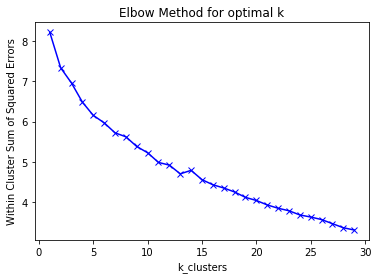

In [48]:
# Elbow Method to find optimal k for k-means algorithm 
WSS = []
k_list = range(1,30)

for k in k_list:
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means = k_means.fit(X)
    WSS.append(k_means.inertia_)

    
plt.plot(k_list, WSS, 'bx-')
plt.xlabel('k_clusters')
plt.ylabel('Within Cluster Sum of Squared Errors')
plt.title('Elbow Method for optimal k')
plt.show()

In [49]:
# Optimal k
k = 10
k_means = KMeans(n_clusters=k, random_state=0)
k_means.fit(X)

k_means.labels_

# Add labels to new dataframe with most common venues
top_venues['Cluster Label'] = k_means.labels_
top_venues.head()

Hood                 1st             2nd  \
0               Agincourt North  Chinese Restaurant  Sandwich Place   
1  Agincourt South-Malvern West  Chinese Restaurant      Food Court   
2                     Alderwood                Park     Gas Station   
3                         Annex                Café      Restaurant   
4             Banbury-Don Mills         Coffee Shop      Restaurant   

                     3rd                   4th           5th  \
0  Vietnamese Restaurant                Bakery   Coffee Shop   
1          Shopping Mall  Cantonese Restaurant    Restaurant   
2            Pizza Place              Pharmacy  Intersection   
3            Coffee Shop    Italian Restaurant        Bakery   
4                   Café                  Bank   Pizza Place   

                   6th                            7th                  8th  \
0                 Bank              Indian Restaurant       Discount Store   
1       Clothing Store             Seafood Restaurant         Noodle House   
2        Grocery Store                            Gym       Sandwich Place   
3    French Restaurant  Vegetarian / Vegan Restaurant  Japanese Restaurant   
4  Japanese Restaurant      Middle Eastern Restaurant     Botanical Garden   

             9th                 10th  Cluster Label  
0       Pharmacy          Pizza Place              4  
1         Lounge          Supermarket              6  
2    Coffee Shop  Moroccan Restaurant              8  
3       Boutique            Gastropub              1  
4  Grocery Store         Gourmet Shop              1

In [50]:
# Merge the results with the neighborhood dataset 
top_venues.rename(columns={'Hood':'Neighborhoods'}, inplace=True)

toronto_merged = pd.merge(neighborhood, top_venues, how='left', on=['Neighborhoods'])
toronto_merged.head()

Neighborhoods              Borough  CDN  Population  \
0               Agincourt North          Scarborough  129     29113.0   
1  Agincourt South-Malvern West          Scarborough  128     23757.0   
2                     Alderwood            Etobicoke   20     12054.0   
3                         Annex  Old City of Toronto   95     30526.0   
4             Banbury-Don Mills           North York   42     27695.0   

    Adults  Avg income  Higher education  Employment rate  Longitude  \
0  11305.0    427037.0           10985.0             50.0 -79.266712   
1   9965.0    278390.0           10285.0             53.2 -79.265612   
2   5220.0    168602.0            5300.0             62.4 -79.541611   
3  15040.0    792507.0           20430.0             65.8 -79.404001   
4  10810.0    493486.0           15950.0             55.6 -79.349718   

    Latitude  ...             2nd                    3rd  \
0  43.805441  ...  Sandwich Place  Vietnamese Restaurant   
1  43.788658  ...      Food Court          Shopping Mall   
2  43.604937  ...     Gas Station            Pizza Place   
3  43.671585  ...      Restaurant            Coffee Shop   
4  43.737657  ...      Restaurant                   Café   

                    4th           5th                  6th  \
0                Bakery   Coffee Shop                 Bank   
1  Cantonese Restaurant    Restaurant       Clothing Store   
2              Pharmacy  Intersection        Grocery Store   
3    Italian Restaurant        Bakery    French Restaurant   
4                  Bank   Pizza Place  Japanese Restaurant   

                             7th                  8th            9th  \
0              Indian Restaurant       Discount Store       Pharmacy   
1             Seafood Restaurant         Noodle House         Lounge   
2                            Gym       Sandwich Place    Coffee Shop   
3  Vegetarian / Vegan Restaurant  Japanese Restaurant       Boutique   
4      Middle Eastern Restaurant     Botanical Garden  Grocery Store   

                  10th Cluster Label  
0          Pizza Place             4  
1          Supermarket             6  
2  Moroccan Restaurant             8  
3            Gastropub             1  
4         Gourmet Shop             1  

[5 rows x 21 columns]

In [51]:
# Convert clusters to int
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Label'] = toronto_merged['Cluster Label'].astype(int)

In [52]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, height=500)

# Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhoods'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Note
This map do not give us much more information about the clusters: what do they represent ? ..

## 4. Explore Toronto Neighborhoods Based on Client Requirements

### Top neighborhoods

In [54]:
# Sort each neighborhood with respect to each criteria set by the client
by_population = neighborhood.sort_values('Population', ascending=False).head(10)
by_income = neighborhood.sort_values('Avg income', ascending=False).head(10)
by_adults = neighborhood.sort_values('Adults', ascending=False).head(10)
by_education = neighborhood.sort_values('Higher education', ascending=False).head(10)
by_employment = neighborhood.sort_values('Employment rate', ascending=False).head(10)

In [55]:
# Concat these top dataframe
# These are the neighborhoods that performs the best for each criteria requested by the client
dfs = [by_population,by_income,by_adults,by_education,by_employment]
top10s = pd.concat(dfs,axis=0)
top10s.head()

Neighborhoods              Borough  CDN  Population  \
122  Waterfront Communities-The Island  Old City of Toronto   77     65913.0   
132                             Woburn          Scarborough  137     53485.0   
129                    Willowdale East           North York   51     50434.0   
105                              Rouge          Scarborough  131     46496.0   
66                          L'Amoreaux          Scarborough  117     43993.0   

      Adults  Avg income  Higher education  Employment rate  Longitude  \
122  45105.0    662333.0           51740.0             78.2 -79.377202   
132  21945.0    629030.0           21370.0             51.9 -79.228586   
129  25850.0    572155.0           32650.0             55.9 -79.401484   
105  18510.0    729154.0           19795.0             59.4 -79.186343   
66   17210.0    529383.0           18765.0             50.4 -79.314084   

      Latitude  
122  43.633880  
132  43.766740  
129  43.770602  
105  43.821201  
66   43.795716

In [56]:
# Check the most common neighborhoods: appearing more than 2 times in a top 10's
# These are the neighborhoods that performs the best for more than one criteria requested by the client
# Let's see if our model will comfirm our assumptions
top10s['Neighborhoods'].value_counts().head(12)

Islington-City Centre West             4
Waterfront Communities-The Island      4
Rouge                                  4
Woburn                                 3
Willowdale East                        3
Niagara                                3
Church-Yonge Corridor                  3
Annex                                  2
Dovercourt-Wallace Emerson-Junction    2
Mimico (includes Humber Bay Shores)    2
Malvern                                2
Mount Pleasant West                    2
Name: Neighborhoods, dtype: int64

In [57]:
# Set a checkpoint for practical use
checkpoint = neighborhood.copy()
checkpoint.head()

Neighborhoods              Borough  CDN  Population  \
0               Agincourt North          Scarborough  129     29113.0   
1  Agincourt South-Malvern West          Scarborough  128     23757.0   
2                     Alderwood            Etobicoke   20     12054.0   
3                         Annex  Old City of Toronto   95     30526.0   
4             Banbury-Don Mills           North York   42     27695.0   

    Adults  Avg income  Higher education  Employment rate  Longitude  \
0  11305.0    427037.0           10985.0             50.0 -79.266712   
1   9965.0    278390.0           10285.0             53.2 -79.265612   
2   5220.0    168602.0            5300.0             62.4 -79.541611   
3  15040.0    792507.0           20430.0             65.8 -79.404001   
4  10810.0    493486.0           15950.0             55.6 -79.349718   

    Latitude  
0  43.805441  
1  43.788658  
2  43.604937  
3  43.671585  
4  43.737657

In [58]:
# Seperate the categorical variables from numerical ones
keys = checkpoint[['Neighborhoods','Borough','CDN','Longitude','Latitude']]
features = checkpoint.iloc[:, 3:8]

### Data standardization

In [60]:
# Calculate median an deviation for each attribute
median = features.median()
std = features.std()

In [61]:
# Manually scale the values using standardization (z = x-u/std) 
# This way we are going to assing a penalty to each neighborhood having a values under median
for i, j in zip(median.iteritems(), std.iteritems()):
    features[i[0]] = features[i[0]].apply(lambda x: (x-i[1])/j[1])
features.head()

Population    Adults  Avg income  Higher education  Employment rate
0    1.232211  0.706225    0.586684          0.448952        -1.312239
1    0.698404  0.459138   -0.056983          0.335087        -0.821108
2   -0.467978 -0.415806   -0.532383         -0.475791         0.590891
3    1.373038  1.394932    2.169230          1.985310         1.112717
4    1.090886  0.614950    0.874419          1.256577        -0.452761

### Neighborhood clustering based on demographic features

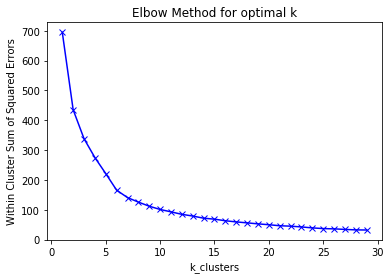

In [62]:
X = features

# Elbow Method to find optimal k for k-means algorithm 
WSS = []
k_list = range(1,30)

for k in k_list:
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means = k_means.fit(X)
    WSS.append(k_means.inertia_)

    
plt.plot(k_list, WSS, 'bx-')
plt.xlabel('k_clusters')
plt.ylabel('Within Cluster Sum of Squared Errors')
plt.title('Elbow Method for optimal k')
plt.show()

In [63]:
# Optimal k
k = 3
k_means = KMeans(n_clusters=k, random_state=0)
k_means.fit(X)

k_means.labels_[0:5]

array([1, 1, 0, 2, 1])

In [64]:
# Add labels to new dataframe with most common venues
checkpoint['Cluster Label'] = k_means.labels_
checkpoint.head()

Neighborhoods              Borough  CDN  Population  \
0               Agincourt North          Scarborough  129     29113.0   
1  Agincourt South-Malvern West          Scarborough  128     23757.0   
2                     Alderwood            Etobicoke   20     12054.0   
3                         Annex  Old City of Toronto   95     30526.0   
4             Banbury-Don Mills           North York   42     27695.0   

    Adults  Avg income  Higher education  Employment rate  Longitude  \
0  11305.0    427037.0           10985.0             50.0 -79.266712   
1   9965.0    278390.0           10285.0             53.2 -79.265612   
2   5220.0    168602.0            5300.0             62.4 -79.541611   
3  15040.0    792507.0           20430.0             65.8 -79.404001   
4  10810.0    493486.0           15950.0             55.6 -79.349718   

    Latitude  Cluster Label  
0  43.805441              1  
1  43.788658              1  
2  43.604937              0  
3  43.671585              2  
4  43.737657              1

In [65]:
# Convert clusters to int
checkpoint.dropna(inplace=True)
checkpoint['Cluster Label'] = checkpoint['Cluster Label'].astype(int)

In [66]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, height=500)

# Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(checkpoint['Latitude'], checkpoint['Longitude'], checkpoint['Neighborhoods'], checkpoint['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Note

By using only attributes as inputs and k=3 we successfully managed to cluster 13 neighborhoods (lightgreen) that seems to confirm our top 10 analysis

## 5. Explore Toronto Neighborhoods Based on Scoring System

### Scoring system 

In [67]:
# Compute a score for each neighborhood considering each attribute as equal
features['Score'] = features.sum(axis=1)
features.head()

Population    Adults  Avg income  Higher education  Employment rate  \
0    1.232211  0.706225    0.586684          0.448952        -1.312239   
1    0.698404  0.459138   -0.056983          0.335087        -0.821108   
2   -0.467978 -0.415806   -0.532383         -0.475791         0.590891   
3    1.373038  1.394932    2.169230          1.985310         1.112717   
4    1.090886  0.614950    0.874419          1.256577        -0.452761   

      Score  
0  1.661832  
1  0.614538  
2 -1.301067  
3  8.035227  
4  3.384071

In [68]:
# Compute a score for each neighborhood considering each attribute having different weight (importance regarding client)
# Score = 0.25*population + 0.25*income + 0.25*adults + 0.15*employment + 0.10*education
features['Weighted score'] = 0.25 * features['Population'] + 0.25 * features['Adults'] + 0.25 * features['Avg income'] + 0.15 * features['Employment rate'] + 0.10 * features['Higher education']
features.head()

Population    Adults  Avg income  Higher education  Employment rate  \
0    1.232211  0.706225    0.586684          0.448952        -1.312239   
1    0.698404  0.459138   -0.056983          0.335087        -0.821108   
2   -0.467978 -0.415806   -0.532383         -0.475791         0.590891   
3    1.373038  1.394932    2.169230          1.985310         1.112717   
4    1.090886  0.614950    0.874419          1.256577        -0.452761   

      Score  Weighted score  
0  1.661832        0.479339  
1  0.614538        0.185482  
2 -1.301067       -0.312987  
3  8.035227        1.599739  
4  3.384071        0.702807

In [69]:
# Group data back 
merged = pd.concat([keys, features], axis=1, sort=False)
merged.head()

Neighborhoods              Borough  CDN  Longitude  \
0               Agincourt North          Scarborough  129 -79.266712   
1  Agincourt South-Malvern West          Scarborough  128 -79.265612   
2                     Alderwood            Etobicoke   20 -79.541611   
3                         Annex  Old City of Toronto   95 -79.404001   
4             Banbury-Don Mills           North York   42 -79.349718   

    Latitude  Population    Adults  Avg income  Higher education  \
0  43.805441    1.232211  0.706225    0.586684          0.448952   
1  43.788658    0.698404  0.459138   -0.056983          0.335087   
2  43.604937   -0.467978 -0.415806   -0.532383         -0.475791   
3  43.671585    1.373038  1.394932    2.169230          1.985310   
4  43.737657    1.090886  0.614950    0.874419          1.256577   

   Employment rate     Score  Weighted score  
0        -1.312239  1.661832        0.479339  
1        -0.821108  0.614538        0.185482  
2         0.590891 -1.301067       -0.312987  
3         1.112717  8.035227        1.599739  
4        -0.452761  3.384071        0.702807

### Top 15 neighborhoods using score

In [70]:
# Filter data to top 15 neighborhoods based on score and wscore
filtered_score = merged.sort_values('Score', ascending=False).head(15)
filtered_wscore = merged.sort_values('Weighted score', ascending=False).head(15)

print('Top 15 neighborhoods with normal score : \n\n', filtered_score['Neighborhoods'].values, '\n')
print('Top 15 neighborhoods with weighted score : \n\n', filtered_wscore['Neighborhoods'].values)

Top 15 neighborhoods with normal score : 

 ['Waterfront Communities-The Island' 'Willowdale East'
 'Islington-City Centre West' 'Niagara' 'Woburn' 'Rouge'
 'Dovercourt-Wallace Emerson-Junction' 'Church-Yonge Corridor' 'Annex'
 'Mimico (includes Humber Bay Shores)' 'Mount Pleasant West' 'Malvern'
 'Rosedale-Moore Park' 'South Riverdale' "L'Amoreaux"] 

Top 15 neighborhoods with weighted score : 

 ['Waterfront Communities-The Island' 'Willowdale East'
 'Islington-City Centre West' 'Woburn' 'Niagara' 'Rouge'
 'Dovercourt-Wallace Emerson-Junction' 'Annex'
 'Mimico (includes Humber Bay Shores)' 'Church-Yonge Corridor' 'Malvern'
 'Rosedale-Moore Park' 'Mount Pleasant West' "L'Amoreaux"
 'South Riverdale']


In [71]:
# They give pretty much the same results
# Let's choose the weighted score to filter our data and represent graphically our neighborhoods
filtered = filtered_wscore
filtered.head()

Neighborhoods              Borough  CDN  Longitude  \
122  Waterfront Communities-The Island  Old City of Toronto   77 -79.377202   
129                    Willowdale East           North York   51 -79.401484   
58          Islington-City Centre West            Etobicoke   14 -79.543317   
132                             Woburn          Scarborough  137 -79.228586   
87                             Niagara  Old City of Toronto   82 -79.412420   

      Latitude  Population    Adults  Avg income  Higher education  \
122  43.633880    4.899892  6.938703    1.605555          7.078308   
129  43.770602    3.357174  3.388219    1.215069          3.973059   
58   43.633463    2.712439  2.427532    2.438203          2.653044   
132  43.766740    3.661252  2.668165    1.461347          2.138214   
87   43.636681    1.438219  2.921705    0.338331          2.452968   

     Employment rate      Score  Weighted score  
122         3.015847  23.538305        4.521245  
129        -0.406717  11.526803        2.326414  
58          0.775065  11.006283        2.276108  
132        -1.020630   8.908347        2.008418  
87          3.706499  10.857722        1.975835

In [72]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10, height=500)

# add markers to map
for lat, lng, borough, neigh in zip(filtered['Latitude'], filtered['Longitude'], filtered['Borough'], filtered['Neighborhoods']):
    label = '{}, {}'.format(neigh, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#750080',
        fill=True,
        fill_color='#800080',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 

map_toronto

##### Note

This looks pretty much the same as our 13 neighborhoods from cluster 2 from previously

### Calling Foursquare API to get venues

In [73]:
# Collecting data about venues for each neighborhoods 
# The query crashes sometimes and need to run again this cell until all neighborhoods get printed
filtered_venues = getAllVenues(names=filtered['Neighborhoods'],
                              latitudes=filtered['Latitude'],
                              longitudes=filtered['Longitude'])

Waterfront Communities-The Island
Willowdale East
Islington-City Centre West
Woburn
Niagara
Rouge
Dovercourt-Wallace Emerson-Junction
Annex
Mimico (includes Humber Bay Shores)
Church-Yonge Corridor
Malvern
Rosedale-Moore Park
Mount Pleasant West
L'Amoreaux
South Riverdale


### Top 100 venues for most scored neighborhoods

In [74]:
# create map of New York using latitude and longitude values
map_filtered_venues = folium.Map(location=[latitude, longitude], zoom_start=10, height = 500)

# add markers to map
for lat, lng, neigh in zip(filtered_venues['Venue Latitude'], filtered_venues['Venue Longitude'], filtered_venues['Neighborhoods']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='#750080',
        fill=True,
        fill_color='#800080',
        fill_opacity=0.7,
        parse_html=False).add_to(map_filtered_venues) 

map_filtered_venues

### One hot encoding 

In [75]:
# Pivot categories: one hot encoding
onehot = pd.get_dummies(filtered_venues[['Venue Category']], prefix="", prefix_sep="")

# Get the neighborhood columns
onehot['Hood'] = filtered_venues['Neighborhoods']
columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[columns]

print(f'The shape of venues in the Top 15 neighborhoods is {onehot.shape}')
onehot.head()

The shape of venues in the Top 15 neighborhoods is (839, 204)


Hood  African Restaurant  American Restaurant  \
0  Waterfront Communities-The Island                   0                    0   
1  Waterfront Communities-The Island                   0                    0   
2  Waterfront Communities-The Island                   0                    0   
3  Waterfront Communities-The Island                   0                    0   
4  Waterfront Communities-The Island                   0                    0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           0                    0                 0   

   Athletics & Sports  Automotive Shop  BBQ Joint  ...  Video Store  \
0                   0                0          0  ...            0   
1                   0                0          0  ...            0   
2                   0                0          0  ...            0   
3                   0                0          0  ...            0   
4                   0                0          0  ...            0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Wings Joint  \
0                      0                0         0          0            0   
1                      0                0         0          0            0   
2                      0                0         0          0            0   
3                      0                0         0          0            0   
4                      0                0         0          0            0   

   Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0              0            0    0            0  
1              0            0    0            0  
2              0            0    0            0  
3              0            0    0            0  
4              0            0    0            0  

[5 rows x 204 columns]

In [76]:
# Group by neighborhood
onehot['Total'] = onehot.sum(axis=1)
onehot.groupby('Hood')['Total'].count().sort_values(ascending=False)

Hood
Niagara                                100
Dovercourt-Wallace Emerson-Junction    100
Church-Yonge Corridor                  100
Annex                                  100
Waterfront Communities-The Island       86
Willowdale East                         56
Islington-City Centre West              55
Mount Pleasant West                     54
Rosedale-Moore Park                     47
L'Amoreaux                              31
Woburn                                  28
Mimico (includes Humber Bay Shores)     26
Rouge                                   24
Malvern                                 18
South Riverdale                         14
Name: Total, dtype: int64

In [77]:
# Group avg number of each categories by neighborhood
onehot_grouped = onehot.groupby(['Hood']).mean().reset_index()

print(f'The shape of the toronto_grouped dataframe is {onehot_grouped.shape}')
onehot_grouped.head()

The shape of the toronto_grouped dataframe is (15, 205)


Hood  African Restaurant  \
0                                Annex                0.00   
1                Church-Yonge Corridor                0.00   
2  Dovercourt-Wallace Emerson-Junction                0.02   
3           Islington-City Centre West                0.00   
4                           L'Amoreaux                0.00   

   American Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0.00         0.00        0.00                 0.01   
1                 0.02         0.00        0.01                 0.01   
2                 0.00         0.02        0.00                 0.00   
3                 0.00         0.00        0.00                 0.00   
4                 0.00         0.00        0.00                 0.00   

   Asian Restaurant  Athletics & Sports  Automotive Shop  BBQ Joint  ...  \
0              0.00                 0.0         0.000000       0.01  ...   
1              0.00                 0.0         0.000000       0.00  ...   
2              0.01                 0.0         0.000000       0.00  ...   
3              0.00                 0.0         0.018182       0.00  ...   
4              0.00                 0.0         0.000000       0.00  ...   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Wings Joint  \
0               0.000000              0.0       0.0        0.0         0.00   
1               0.000000              0.0       0.0        0.0         0.01   
2               0.010000              0.0       0.0        0.0         0.00   
3               0.036364              0.0       0.0        0.0         0.00   
4               0.000000              0.0       0.0        0.0         0.00   

   Women's Store  Yoga Studio  Zoo  Zoo Exhibit  Total  
0       0.000000         0.00  0.0          0.0      1  
1       0.000000         0.01  0.0          0.0      1  
2       0.000000         0.00  0.0          0.0      1  
3       0.018182         0.00  0.0          0.0      1  
4       0.000000         0.00  0.0          0.0      1  

[5 rows x 205 columns]

### Neighborhood clustering based on scoring system

In [78]:
X = onehot_grouped.drop('Hood', axis=1)

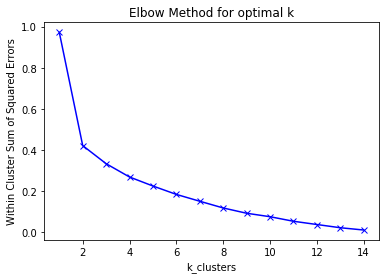

In [79]:
# Elbow Method to find optimal k for k-means algorithm 
WSS = []
k_list = range(1,15)

for k in k_list:
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means = k_means.fit(X)
    WSS.append(k_means.inertia_)

    
plt.plot(k_list, WSS, 'bx-')
plt.xlabel('k_clusters')
plt.ylabel('Within Cluster Sum of Squared Errors')
plt.title('Elbow Method for optimal k')
plt.show()

In [80]:
# Optimal k
k = 3
k_means = KMeans(n_clusters=k, random_state=0)
k_means.fit(X)

k_means.labels_

# Add labels to new dataframe with most common venues
filtered['Cluster Label'] = k_means.labels_
filtered.head()

Neighborhoods              Borough  CDN  Longitude  \
122  Waterfront Communities-The Island  Old City of Toronto   77 -79.377202   
129                    Willowdale East           North York   51 -79.401484   
58          Islington-City Centre West            Etobicoke   14 -79.543317   
132                             Woburn          Scarborough  137 -79.228586   
87                             Niagara  Old City of Toronto   82 -79.412420   

      Latitude  Population    Adults  Avg income  Higher education  \
122  43.633880    4.899892  6.938703    1.605555          7.078308   
129  43.770602    3.357174  3.388219    1.215069          3.973059   
58   43.633463    2.712439  2.427532    2.438203          2.653044   
132  43.766740    3.661252  2.668165    1.461347          2.138214   
87   43.636681    1.438219  2.921705    0.338331          2.452968   

     Employment rate      Score  Weighted score  Cluster Label  
122         3.015847  23.538305        4.521245              0  
129        -0.406717  11.526803        2.326414              0  
58          0.775065  11.006283        2.276108              0  
132        -1.020630   8.908347        2.008418              0  
87          3.706499  10.857722        1.975835              0

In [81]:
# Convert clusters to int
filtered.dropna(inplace=True)
filtered['Cluster Label'] = filtered['Cluster Label'].astype(int)

In [82]:
# Create map
map_filtered_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, height=500)

# Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(filtered['Latitude'], filtered['Longitude'], filtered['Neighborhoods'], filtered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_filtered_clusters)
       
map_filtered_clusters

##### Note
According to this map, the top 15 neighborhoods chosen seems to be very much similar as it did not equally split the neighborhood into clusters. Combining this result to previous analysis, we came to the concluison that these neighborhoods are the one that best meet the client requirements and tend to be similar base on the venue catagories.

#### Next Step
A report summarizing the methodology and conclusion of this analysis is on going and will be soon available